---
# **Plotting Video Metrics using FFMPEG w libVMAF**

---
>Google Colab
1. Takes a MP4 video file as input (Video)
2. Adds Compression Noise to the video (Video+Noise)
3. Calculates Video quality metrics on Video+Noise file, using Video file as the reference
4. TBD Plots the video quality metrics for each frame

---
>**Input:**
* MP4 video (<30MB -- larger will cause runtime to disconnect)

>**Output:**
* Mean PSNR/SSIM/VMAF
* Plots of Metrics for each frame
---

Download and Uncompress FFMPEG w LibVMAF
> Note: FFMPEG normal build does not include VMAF

In [ ]:
#install ffmpeg
#!pip install ffmpeg

#make directory
!mkdir "ffmpeg-git-amd64-static"

#install ffmpeg with libvmaf (prebuilt)
!wget https://johnvansickle.com/ffmpeg/builds/ffmpeg-git-amd64-static.tar.xz
!tar -xvf "ffmpeg-git-amd64-static.tar.xz" --directory "ffmpeg-git-amd64-static" --strip-components=1

--2023-11-13 17:23:35--  https://johnvansickle.com/ffmpeg/builds/ffmpeg-git-amd64-static.tar.xz
Resolving johnvansickle.com (johnvansickle.com)... 107.180.57.212
Connecting to johnvansickle.com (johnvansickle.com)|107.180.57.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41351448 (39M) [application/x-xz]
Saving to: ‘ffmpeg-git-amd64-static.tar.xz’

ffmpeg-git-amd64-st 100%[===================>]  39.44M  14.1MB/s    in 2.8s    

2023-11-13 17:23:38 (14.1 MB/s) - ‘ffmpeg-git-amd64-static.tar.xz’ saved [41351448/41351448]

ffmpeg-git-20231103-amd64-static/GPLv3.txt
ffmpeg-git-20231103-amd64-static/manpages/
ffmpeg-git-20231103-amd64-static/manpages/ffmpeg-all.txt
ffmpeg-git-20231103-amd64-static/manpages/ffmpeg-scaler.txt
ffmpeg-git-20231103-amd64-static/manpages/ffmpeg-resampler.txt
ffmpeg-git-20231103-amd64-static/manpages/ffmpeg-filters.txt
ffmpeg-git-20231103-amd64-static/manpages/ffprobe.txt
ffmpeg-git-20231103-amd64-static/manpages/ffmpeg-devices.txt
f

Prompts user to choose video file to be used as input

> Make sure video file is small. Video files larger that 30MB may take longer to process or disconnect the runtime.


In [ ]:
#import video file into local directory /content/
#Example input video: https://drive.google.com/file/d/1-z98fyhQMMNgVURPtuJj2aBN-rRnHxEV/view?usp=drive_link
from google.colab import files

video = files.upload()

input_file="input.mp4"

Saving input.mp4 to input.mp4


In [ ]:
#lists parameters of each frame in video
#output=!ffmpeg-git-20231006-amd64-static/ffprobe -hide_banner -v error -select_streams v:0 -show_frames input.mp4
#print(output)

# Applies varying levels of compression to input video
> Output is saved as "input_with_noise-CRF.mp4", where CRF is the level of compression


In [ ]:
#Compress Video
#CRF is constant rate factor. Higher CRF (30) produces smaller video file size, with lower quality. Lower CRF produces larger file size, but higher quality video.
#CRF=20 is reommended for most uses.
for crf in [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70]:
  !ffmpeg-git-amd64-static/ffmpeg -hide_banner -i input.mp4 -vcodec libx264 -pix_fmt yuv420p -crf {crf} -y input_with_noise-{crf}.mp4 -loglevel error


Calculates Video Quality Metrics (PSNR, SSIM and VMAF) on "Input_with_noise.mp4"
> Reference video is "input.mp4"
> Logs are stored in JSON format in "metric.log"



In [ ]:
# Calculate per frame PSNR, SSIM, VMAF. Caution: this may take a while.
for crf in [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70]:
  metric_log = 'metric-{'+str(crf)+'}.log'
  !ffmpeg-git-amd64-static/ffmpeg -hide_banner -i input_with_noise-{crf}.mp4 -i input.mp4 -filter_complex libvmaf='feature=name=psnr|name=float_ssim:log_path={metric_log}:log_fmt=json' -f null -

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'input_with_noise-0.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    title           : 1064319234
    encoder         : Lavf60.17.100
    comment         : This video is subject to copyright.
    copyright       : This video is subject to copyright.
  Duration: 00:00:12.84, start: 0.000000, bitrate: 8759 kb/s
  Stream #0:0[0x1](eng): Video: h264 (High 4:4:4 Predictive) (avc1 / 0x31637661), yuv420p(progressive), 640x360 [SAR 1:1 DAR 16:9], 8758 kb/s, 25 fps, 25 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : MP4 Video Media Handler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc60.32.102 libx264
Input #1, mov,mp4,m4a,3gp,3g2,mj2, from 'input.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isom
    creation_time   : 2018-11-12T09:41:40.000000Z
    comment         : This video is subject to copyright.
    cop

Prints out the Mean of each metric (PSNR, SSIM, VMAF) for all frames
> This comes from last entries of "metric.log"
* PSNR scale is 0 (worst) to 60 (best)
* SSIM scale is -1 (worst), 0 (no similarity), 1 (best)
* VMAF scale is 0 (worst) to 100 (best)





In [ ]:
#print out the Mean of the Metrics (PSNR, SSIM, VMAF)
import json

x=[]
psnr_y=[]
ssim_y=[]
vmaf_y=[]
metric_data=[None]*71

for crf in [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70]:
  with open('metric-{'+str(crf)+'}.log') as f:
    data = json.load(f)
  psnr_avg=data['pooled_metrics']['psnr_y']['mean']
  ssim_avg=data['pooled_metrics']['float_ssim']['mean']
  vmaf_avg=data['pooled_metrics']['vmaf']['mean']
  print('========='+str(crf)+'========')
  print("PSNR Mean: ", psnr_avg)
  print("SSIM Mean: ", ssim_avg)
  print("VMAF Mean: ", vmaf_avg)

  metric_data[crf]={"psnr": (crf,psnr_avg),"ssim": (crf,ssim_avg),"vmaf": (crf,vmaf_avg)}
  x.append(crf)
  psnr_y.append(psnr_avg)
  ssim_y.append(ssim_avg)
  vmaf_y.append(vmaf_avg)

=========0========
PSNR Mean:  60.0
SSIM Mean:  1.0
VMAF Mean:  99.344876
=========5========
PSNR Mean:  55.061129
SSIM Mean:  0.999085
VMAF Mean:  99.260434
=========10========
PSNR Mean:  50.285349
SSIM Mean:  0.997393
VMAF Mean:  99.111534
=========15========
PSNR Mean:  45.615447
SSIM Mean:  0.993101
VMAF Mean:  98.666144
=========20========
PSNR Mean:  40.920891
SSIM Mean:  0.982165
VMAF Mean:  97.389159
=========25========
PSNR Mean:  36.592002
SSIM Mean:  0.957049
VMAF Mean:  94.264474
=========30========
PSNR Mean:  32.823427
SSIM Mean:  0.904649
VMAF Mean:  87.63555
=========35========
PSNR Mean:  29.628736
SSIM Mean:  0.827801
VMAF Mean:  76.166063
=========40========
PSNR Mean:  26.958401
SSIM Mean:  0.756905
VMAF Mean:  59.566306
=========45========
PSNR Mean:  24.654048
SSIM Mean:  0.693394
VMAF Mean:  39.614015
=========50========
PSNR Mean:  22.581693
SSIM Mean:  0.622633
VMAF Mean:  20.91261
=========55========
PSNR Mean:  22.279743
SSIM Mean:  0.611467
VMAF Mean:  17.7

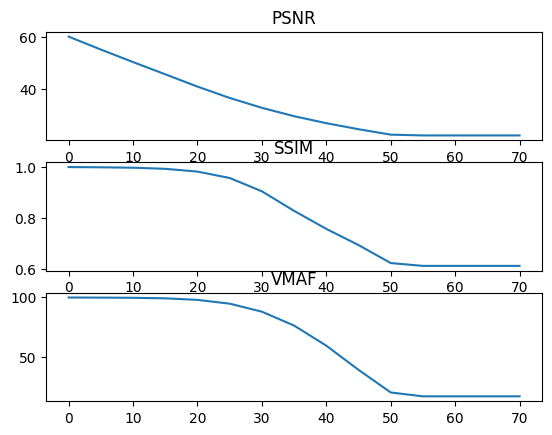

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(x,psnr_y, label="psnr")
ax1.set_title("PSNR")

ax2.plot(x,ssim_y, label="ssim")
ax2.set_title("SSIM")

ax3.plot(x,vmaf_y, label="vmaf")
ax3.set_title("VMAF")

plt.show()

---
That's it for now...

---

